#Fruit inspection: second task

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from google.colab.patches import cv2_imshow
from scipy.spatial.distance import cdist
from scipy.spatial import distance

Chose the image and read it.

In [ ]:
SELECTED_IMAGE = 1 # 0 or 1

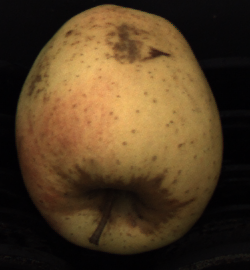

In [ ]:
if SELECTED_IMAGE:
    image_bgr = cv2.imread("C1_000004.png")
    image_nir = cv2.imread("C0_000004.png",cv2.IMREAD_GRAYSCALE)

else:
    image_bgr = cv2.imread("C1_000005.png")
    image_nir = cv2.imread("C0_000005.png",cv2.IMREAD_GRAYSCALE)
cv2_imshow(image_bgr)


##Extracting the apple mask

As we did in the first task, the image has been binarized using an adaptive thresholding in order to extract the apple contour.

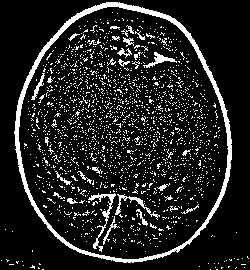

In [ ]:
t_image = cv2.adaptiveThreshold(image_nir,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,13,3)
cv2_imshow(t_image)

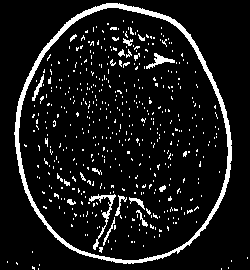

In [ ]:
t_open_image = cv2.morphologyEx(t_image, cv2.MORPH_OPEN, (3,3))
cv2_imshow(t_open_image)

In [ ]:
contours, hierarchy = cv2.findContours(t_open_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

In [ ]:
def argmax_contour(contours):
  maxArea = 0
  argmax_area = None
  for i,c in enumerate(contours):
    if cv2.contourArea(c) > maxArea:
      maxArea = cv2.contourArea(c)
      argmax_area = i
  return argmax_area

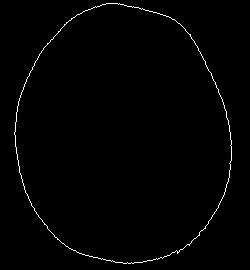

In [ ]:
mask=np.zeros(image_nir.shape, np.uint8)
cnt = contours[argmax_contour(contours)]
cv2.drawContours(mask, [cnt], 0, (255,255,255), 1)
cv2_imshow(mask)
mask_filled = mask.copy()

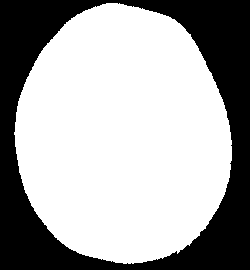

In [ ]:
cv2.fillPoly(mask_filled, pts =[cnt], color=(255,255,255))
cv2_imshow(mask_filled)

Before applying the mask, the image has been blurred using a median filter in order to preserve the russets borders.

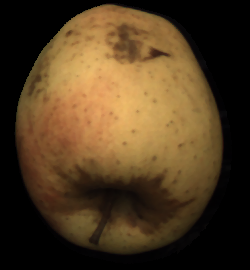

In [ ]:
blurred_bgr = cv2.medianBlur(image_bgr, 3)
masked_image = cv2.bitwise_and(blurred_bgr, blurred_bgr, mask=mask_filled)
cv2_imshow(masked_image)

In order to extract the russets zones we can use the concept of mahalanobis distance.
First step is to compute the mean and the inverse of the covariance matrix of samples taken from russets zones. The idea is to extract, from multiple samples a single mean coor value and a single covariance matrix.

The final color space that I used is the LAB color space, which separates the light signal from the color signal (A and B). This is very useful in our case because we want to separate areas with similar colors to the one of the russet areas.

In [ ]:
samples_name = ["sample4_unique1.png", "sample4_unique2.png"]
final_mean = np.zeros((1, 2), dtype="float64")
final_cov = np.zeros((2, 2), dtype="float64")

for i in samples_name:
    sample= cv2.imread(i)
    sampleAB= cv2.cvtColor(sample, cv2.COLOR_BGR2LAB)[:, :, 1:3]
    sampleAB = sampleAB.reshape(sampleAB.shape[0] * sampleAB.shape[1], 2)
    cov, mean = cv2.calcCovarMatrix(sampleAB, None, cv2.COVAR_NORMAL | cv2.COVAR_ROWS | cv2.COVAR_SCALE)
    final_cov += cov
    final_mean += mean
final_mean = final_mean/len(samples_name)
icov = cv2.invert(final_cov, cv2.DECOMP_SVD)

The next step is to compute the mahalanobis distance of all the pixels and show the result.

In [ ]:
dist=np.zeros((masked_image.shape[0],masked_image.shape[1]))
masked_image= cv2.cvtColor(masked_image, cv2.COLOR_BGR2LAB)
for i in range(masked_image.shape[0]):
    for j in range(masked_image.shape[1]):
        point = np.array(masked_image[i][j])[1:3].reshape(1, 2)
        dist[i][j] = cdist(point, final_mean, 'mahalanobis', VI=icov[1])

Then we normalize the matrix dist and we multiply it by 255, so that the new range of distances goes from 0 to 255.

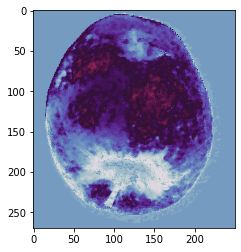

In [ ]:
dist = np.divide(dist, np.max(dist)) * 255
plt.imshow(dist, cmap='twilight',vmin=np.min(dist), vmax=np.max(dist))
plt.show()

The values of the russet areas can differ from image to image, but in general the russet area shows much lower values with respect to the other areras of the apple. In this case I decided to apply an adaptive threshold with very big block size in order to extract as best as possible the full russet area.

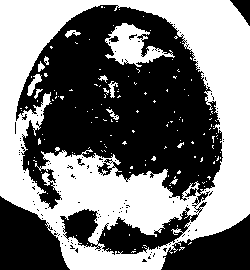

In [ ]:
dist = dist.astype(np.uint8)

th_dist = cv2.adaptiveThreshold(dist,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY_INV,231,2)
cv2_imshow(th_dist)

#th,th_dist = cv2.threshold(dist,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#th_dist = 255-th_dist

Then, since we are interested in the contours in the apple contour, we can use the mask of the apple found before to remove all the white pixels that don't belong to the apple.

So the next step is to take the mask, dilate it and apply it t othe thresholded image. 

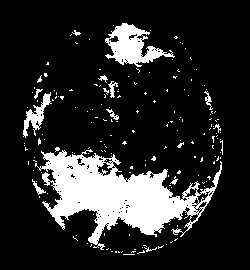

In [ ]:
background = 255 - mask_filled

kernel = np.ones((5, 5), np.uint8)
russets = th_dist.copy()
mask_filled = cv2.erode(mask_filled, kernel, iterations=4)
russets[np.where(mask_filled==0)] = 0
cv2_imshow(russets)

Now, as we can observe, the image presents a lot of noise. In order to remove it, I followed the following steps using a 5x5 kernel:



1.   Closing of the russets zones
2.   Opening of the russets zones
3.   Erosion of the russets zones



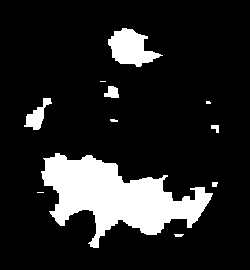

In [ ]:
kernel = np.ones((5,5),np.uint8)
russets = cv2.morphologyEx(russets, cv2.MORPH_CLOSE, kernel)
russets = cv2.morphologyEx(russets, cv2.MORPH_OPEN, kernel)
dilation = cv2.erode(russets,(5,5),iterations = 5)
cv2_imshow(dilation)

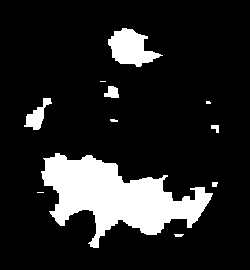

In [ ]:
dilation = cv2.erode(russets,(5,5),iterations = 5)
cv2_imshow(dilation)
#dilation= russets

Now the image is much more clear, and we can run a find contour algorthm.

In [ ]:
contours, hierarchy = cv2.findContours(dilation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

Since not all the contours found are russets zones, but they comprehend some false positive: a contour is a true positive if it respects the following criteria (all the parameters have been chosen empirically). 


1.   Area of the contour larger then 320
2.   The mean of the hue value of the points on the borders of the russet zones less then 23
3.   The mean mahalanobis distance of the points inside the contour is less then 105



In [ ]:
def checkContourPixels(contour, dist):
    mean = 0
    count= 0
    for i in range(dist.shape[0]):
        for j in range(dist.shape[1]):
            if cv2.pointPolygonTest(contour, (i,j), False) >= 0:
              mean += dist[i,j]
              count += 1
    mean_final = mean / count
    print("mean final", mean_final)
    return mean_final < 105

In [ ]:
img_hsv = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2HSV)

good_contours = []

for i,c in enumerate(contours):
    area = cv2.contourArea(c)
    perimeter = cv2.arcLength(c,True)

    blank=np.zeros(image_nir.shape,np.uint8)
    cv2.drawContours(blank,contours,i,(255,255,255),-1)
    locs = np.where(blank == 255)
    h,s,v=cv2.split(img_hsv)
    pixels = h[locs]
    mean_h=np.mean(pixels)
    if(mean_h<23) and area>320 and checkContourPixels(c, dist):
        good_contours.append(c)

mean final 93.45855288523326
mean final 100.79543602281989


In this way only the true positives are detected. The last step consists in show the final image with bounding boxes around the russets zones detected.

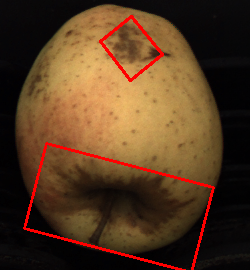

In [ ]:
contours_image= cv2.cvtColor(img_hsv, cv2.COLOR_HSV2BGR)
for c in good_contours:
  rect = cv2.minAreaRect(c)
  box = cv2.boxPoints(rect)
  box = np.int0(box)
  cv2.drawContours(contours_image,[box],0,(0,0,255),2)
cv2_imshow(contours_image)